# Criminal Recidivism Prediction

### Preparations

In [1]:
# !python chapter_setup.py

### Loading Libraries

In [66]:
# Install the missing library
!apt-get update && apt-get install -y libgl1-mesa-glx

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 Packages [8,066 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [376 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Fetched 8,648 kB in 2s (5,633 kB/s)




The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libllvm11 libpciaccess0 libsensors-config libsensors5 libvulkan1
  libwayland-client0 libx11-xcb1 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0
  libxcb-present0 libxcb-randr0 libxcb-sync1 libxcb-xfixes0 libxshmfence1
  libxxf86vm1 libz3-4 mesa-vulkan-drivers
Suggested packages:
  pciutils l

In [78]:
# Computing Libraries
import math
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Datasets Source
import machine_learning_datasets as mldatasets

# Scikit-Learn
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Categorical Boosting
from catboost import CatBoostClassifier

# TensorFlow
import tensorflow as tf

# Alibi
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular, CounterfactualProto

# Model Interpreter
import shap
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [81]:
print(tf.__version__) 

2.15.1


In [84]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly())

Eager execution enabled:  False


### Understanding & Preparing Data

In [108]:
#Former Loading
recidivism_df = mldatasets.load("recidivism-risk", prepare=True)

https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv downloaded to /datasets/_deepnote_work/data/cox-violent-parsed_filt.csv
1 dataset files found in /datasets/_deepnote_work/data folder
parsing /datasets/_deepnote_work/data/cox-violent-parsed_filt.csv


In [111]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14788 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    14788 non-null  int8 
 1   juv_fel_count          14788 non-null  int8 
 2   juv_misd_count         14788 non-null  int8 
 3   juv_other_count        14788 non-null  int64
 4   priors_count           14788 non-null  int8 
 5   is_recid               14788 non-null  int8 
 6   sex_Female             14788 non-null  uint8
 7   sex_Male               14788 non-null  uint8
 8   race_African-American  14788 non-null  uint8
 9   race_Asian             14788 non-null  uint8
 10  race_Caucasian         14788 non-null  uint8
 11  race_Hispanic          14788 non-null  uint8
 12  race_Native American   14788 non-null  uint8
 13  race_Other             14788 non-null  uint8
 14  c_charge_degree_(F1)   14788 non-null  uint8
 15  c_charge_degree_(F2)   14788 non-nul

In [114]:
recidivism_df.age.describe()

count    14788.000000
mean        33.622938
std         11.452577
min         18.000000
25%         25.000000
50%         30.000000
75%         40.000000
max         96.000000
Name: age, dtype: float64

### Examining Predictive Bias with Confusion Matrices

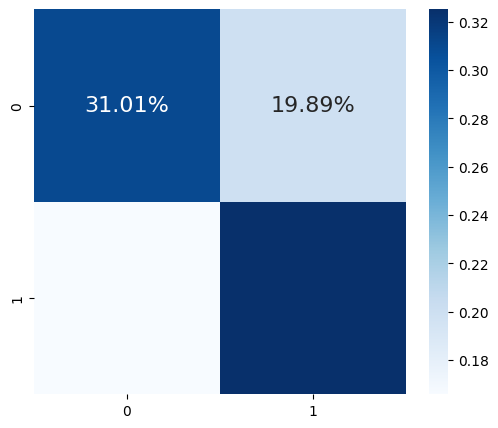

In [117]:
cf_matrix = metrics.confusion_matrix(recidivism_df.is_recid,\
                                     recidivism_df.compas_score)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

In [123]:
# Using 'decile_score' as a proxy for 'compas_score'
cf_matrix = metrics.confusion_matrix(recidivism_df.is_recid, recidivism_df.decile_score)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

AttributeError: 'DataFrame' object has no attribute 'decile_score'

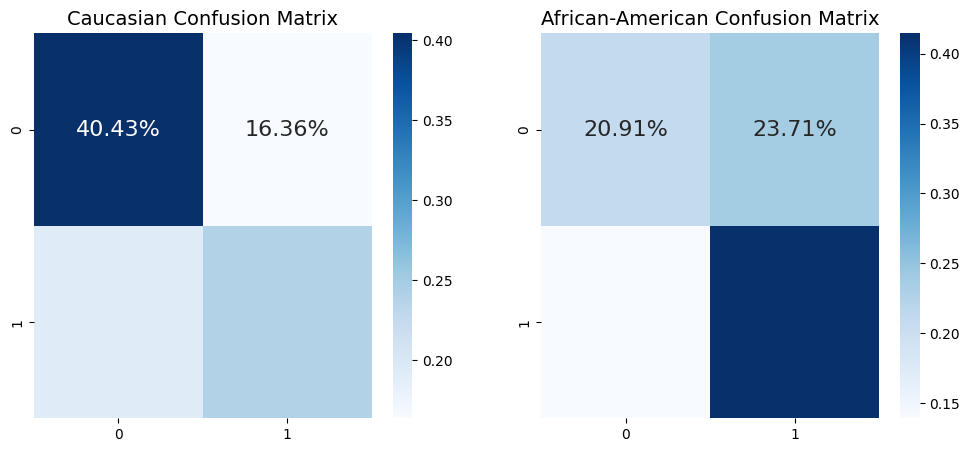

	African-American FPR:	53.1%
	Caucasian FPR:		28.8%
	Ratio FPRs:		1.84 x


In [126]:
recidivism_c_df = recidivism_df[recidivism_df['race_Caucasian'] == 1]
recidivism_aa_df = recidivism_df[recidivism_df['race_African-American'] == 1]

_ = mldatasets.\
      compare_confusion_matrices(recidivism_c_df.is_recid, 
                                 recidivism_c_df.compas_score,\
                                 recidivism_aa_df.is_recid,\
                                 recidivism_aa_df.compas_score,\
                                 'Caucasian', 'African-American', compare_fpr=True) 

- Data Preparation

In [129]:
#Random Seed
rand = 9
np.random.seed(rand)

# Target
y = recidivism_df['compas_score']

# Features
X = recidivism_df.drop(['compas_score', 'is_recid'], axis=1).copy()

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

- Modeling

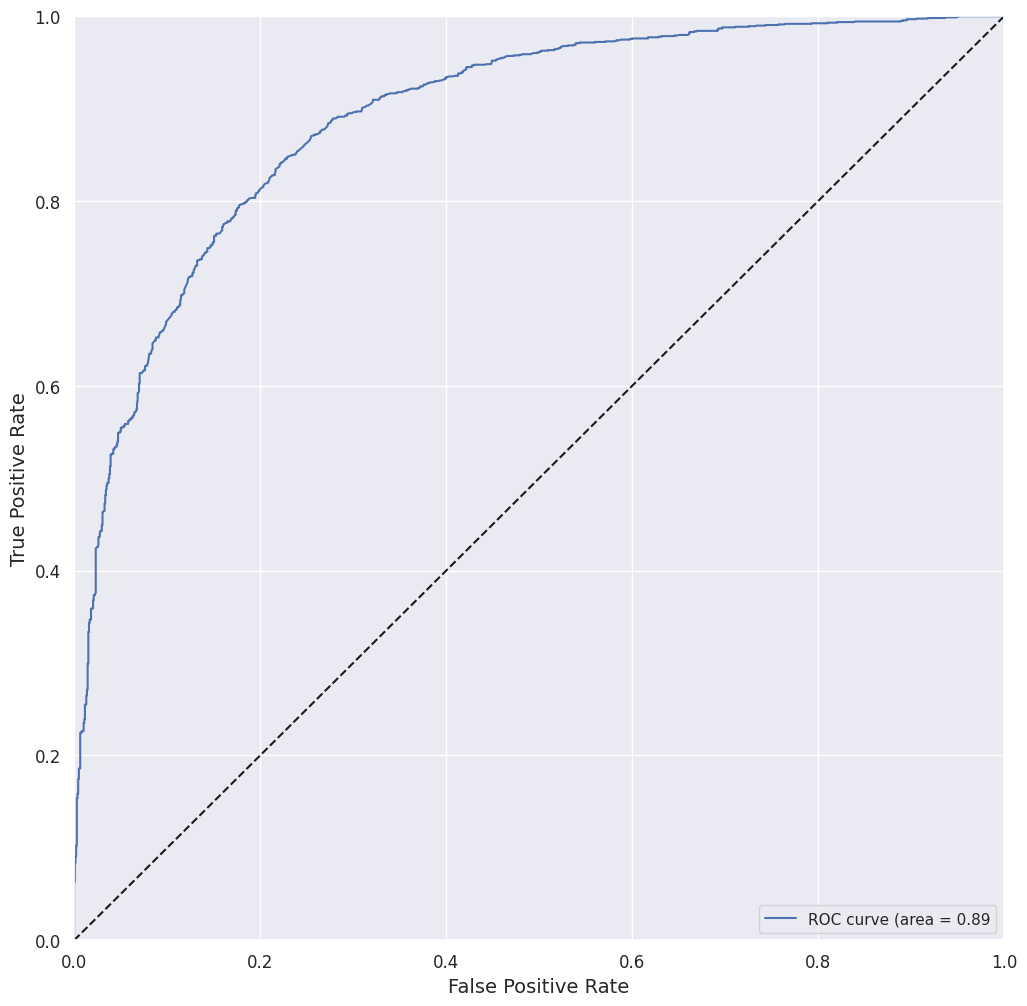

Accuracy_train:  0.8790		Accuracy_test:   0.8063
Precision_test:  0.8261		Recall_test:     0.8078
ROC-AUC_test:    0.8909		F1_test:         0.8169		MCC_test: 0.6115


In [132]:
orig_plt_params = plt.rcParams

sns.set()

cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        mldatasets.evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test) 

- Getting Acquainted to our “Instance of Interest”

In [135]:
idx_aa = 5231
idx_h = 2726
idx_c = 10127

eval_idxs = X_test.index.isin([idx_aa, idx_h, idx_c])
X_test_evals = X_test[eval_idxs]

eval_compare_df = pd.concat([\
            pd.DataFrame({'y':y_test[eval_idxs]},\
                         index=[idx_c, idx_h, idx_aa]),\
            pd.DataFrame({'y_pred':y_test_cb_pred[eval_idxs]},\
                         index=[idx_c, idx_h, idx_aa]),\
            X_test_evals], axis=1).transpose()

eval_compare_df

,10127,2726,5231
y,0,0,1
y_pred,0,0,1
age,24,23,23
juv_fel_count,0,0,0
juv_misd_count,0,0,0
juv_other_count,0,0,0
priors_count,2,2,2
sex_Female,0,0,0
sex_Male,1,1,1
race_African-American,0,0,1


## Understanding Anchor Explanations

### Preparations for Anchor & Counterfactual Explanations with Alibi

In [138]:
class_names = ['Low Risk', 'Medium/High Risk']

In [141]:
X_test_eval = np.expand_dims(X_test.values[X_test.\
                                           index.get_loc(idx_aa)], axis=0)
print(X_test_eval)

[[23  0  0  0  2  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]]


In [144]:
cat_vars_ohe = {5: 2, 7: 6, 13: 8}

print(ohe_to_ord(X_test_eval, cat_vars_ohe)[0])

[[23  0  0  0  2  1  0  3]]


In [147]:
category_map = {
    5: ['Female', 'Male'],
    6: ['African-American', 'Asian', 'Caucasian',\
        'Hispanic', 'Native American', 'Other'],
    7: ['Felony 1st Degree', 'Felony 2nd Degree',\
        'Felony 3rd Degree', 'Felony 7th Degree',\
        'Misdemeanor 1st Degree', 'Misdemeanor 2nd Degree',\
        'Misdemeanor 3rd Degree', 'Other Charge Degree']
}
feature_names = ['age', 'juv_fel_count', 'juv_misd_count',\
                 'juv_other_count', 'priors_count', 
                 'sex', 'race', 'c_charge_degree']

In [150]:
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

### Local Interpretations for Anchor Explanations

In [153]:
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)

anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)

anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [156]:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[idx_aa].values)[0]])

Prediction: Medium/High Risk


In [159]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx_aa].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American
Precision: 0.901
Coverage: 0.125


In [162]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx_aa].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	race_Caucasian = Not Caucasian AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	c_charge_degree_(M2) = Not Misdemeanor 2nd Deg
Precision: 0.906
Coverage: 0.099


In [165]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx_c].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage) 

Anchor: priors_count <= 2.00 AND
	c_charge_degree_(M1) = Misdemeanor 1st Deg AND
	race_African-American = Not African American
Precision: 0.854
Coverage: 0.105


In [168]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx_h].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	race_Hispanic = Hispanic AND
	juv_fel_count <= 0.00 AND
	juv_other_count <= 0.00
Precision: 0.854
Coverage: 0.052


## Exploring Counterfactual Explanations

### Counterfactual Explanations Guided by Prototypes

In [171]:
feature_range = (X_train.values.min(axis=0).reshape(1,21).astype(np.float32),\
                 X_train.values.max(axis=0).reshape(1,21).astype(np.float32))

print(feature_range)

(array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32))


In [174]:
# Random Seed
np.random.seed(rand)
tf.random.set_seed(rand)

# Model
cf_cb_explainer = CounterfactualProto(predict_cb_fn,
                                    X_test_eval.shape,
                                    max_iterations=500,
                                    feature_range=feature_range, 
                                    beta=.01, theta=5,\
                                    c_init = 1., c_steps = 2,
                                    use_kdtree=True
                                )
cf_cb_explainer.fit(X_test.values, d_type='abdm-mvdm')

No encoder specified. Using k-d trees to represent class prototypes.


CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.01,
              'gamma': 0.0,
              'theta': 5,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 500,
              'c_init': 1.0,
              'c_steps': 2,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)),
              'shape': (1, 21),
              'is_mo

In [177]:
%%time
cf_cb_explanation = cf_cb_explainer.explain(X_test_eval)
mldatasets.describe_cf_instance(X_test_eval, cf_cb_explanation, class_names,\
                  cat_vars_ohe, category_map, feature_names)

2025-06-15 20:40:56.415079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
Instance Outcomes and Probabilities
------------------------------------------------
       original:  Medium/High Risk
                  [0.29141184 0.70858816]
 counterfactual:  Low Risk
                  [0.95476873 0.04523127]

Categorical Feature Counterfactual Perturbations
------------------------------------------------
	           race:  African-American  -->  Hispanic

Numerical Feature Counterfactual Perturbations
------------------------------------------------
CPU times: user 2.96 s, sys: 2.02 s, total: 4.98 s
Wall time: 2.55 s


## Counterfactual Instances and much more with the What-If-Tool (WIT)

- Configuring WIT

In [180]:
shap_cb_explainer = shap.TreeExplainer(fitted_cb_mdl)

In [183]:
test_df = recidivism_df.loc[y_test.index]

test_np = test_df.values

cols_l = test_df.columns

delcol_idx = [cols_l.get_loc("is_recid"),\
              cols_l.get_loc("compas_score")]

In [186]:
def custom_predict_with_shap(examples_np):
    #For shap values we only need the same features
    #that were used for training
    inputs_np = np.delete(np.array(examples_np),\
                          delcol_idx, axis=1)

    #Get the model's class predictions
    preds = predict_cb_fn(inputs_np)

    #With test data generate SHAP values which converted
    #to a list of dictionaries format
    keepcols_l = [c for i, c in enumerate(cols_l)\
                  if i not in delcol_idx]
    shap_output = shap_cb_explainer.shap_values(inputs_np)
    attributions = []
    for shap in shap_output:
        attrs = {}
        for i, col in enumerate(keepcols_l):
            attrs[col] = shap[i]
        attributions.append(attrs)
        
    #Prediction function must output 
    #predictions/attributions in dictionary
    output = {'predictions': preds,\
              'attributions': attributions}
    return output

- Displaying WIT

In [189]:
print(y_test.index.get_loc(5231))

2910


In [195]:
# wit_config_builder = WitConfigBuilder(\
#                     test_np.tolist(), feature_names=cols_l.tolist()
#                 ).set_custom_predict_fn(custom_predict_with_shap).\
#                 set_target_feature("is_recid").set_label_vocab(class_names)

# WitWidget(wit_config_builder, height=800)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cbffc8e6-abe2-4abd-875a-868ff050aad3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>